## Analiza danych i zbudowanie modeli predykcyjnych

### Piotr Mariusz Kozikowski

---

Na potrzeby zrealizowanej analizy danych, zdecydowano się na wybór zbioru danych dotyczącego przejazdów żółtych taksówek (ang. *yellow taxis*) w Nowym Jorku, obejmującego I kwartał 2024 r. 

#### Import niezbędnych bibliotek do wczytania danych i przeprowadzenia analizy danych

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plot_utils as pu
import data_utils as du

#### Wczytanie plików w formacie Parquet do ramek danych Pandas

In [2]:
# Wczytanie plików ze zbiorami danych w formacie Parquet
file_name = "data/yellow_tripdata_2024-xx.parquet"

# Utworzenie ramek danych poprzez wczytanie wybranych plików z danymi
df_1 = pd.read_parquet(file_name.replace("xx", "01"))
df_2 = pd.read_parquet(file_name.replace("xx", "02"))
df_3 = pd.read_parquet(file_name.replace("xx", "03"))

# Połączenie powstałych ramek danych w jedną ramkę
df = pd.concat([df_1, df_2, df_3])

# Zresetowanie indeksu w ramce danych w celu zachowania jednolitości
df.reset_index(inplace=True, drop=True)

In [3]:
# Wyświetlenie pierwszych pięciu wierszy we wczytanej ramce danych
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [4]:
# Wyświetlenie ostatnich pięciu wierszy we wczytanej ramce danych
df.tail()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
9554773,2,2024-03-31 23:16:45,2024-03-31 23:29:20,NaN,4.27,NaN,None,130,218,0,14.27,0.0,0.5,0.00,0.0,1.0,15.77,NaN,NaN
9554774,1,2024-03-31 23:29:28,2024-03-31 23:43:47,NaN,0.00,NaN,None,79,100,0,14.00,1.0,0.5,3.80,0.0,1.0,24.80,NaN,NaN
9554775,2,2024-03-31 23:15:00,2024-03-31 23:47:29,NaN,6.44,NaN,None,63,181,0,30.00,0.0,0.5,0.00,0.0,1.0,31.50,NaN,NaN
9554776,2,2024-03-31 23:27:53,2024-03-31 23:45:44,NaN,3.88,NaN,None,161,148,0,22.32,0.0,0.5,5.26,0.0,1.0,31.58,NaN,NaN
9554777,2,2024-03-31 23:10:50,2024-03-31 23:31:59,NaN,7.39,NaN,None,95,7,0,31.47,0.0,0.5,0.00,0.0,1.0,32.97,NaN,NaN


### Etap 1. analizy jakościowej - wstępna analiza statystyczna i dodanie pomocniczych kolumn

In [5]:
# Mapowanie numerów identyfikacyjnych dostawców systemów TPEP na ich inicjały lub krótkie nazwy
vendor_names = {1: 'CMT', 2: 'CM', 6: 'MT', 7: 'Helix'}

# Utworzenie kolumny zawierającej inicjały lub nazwy dostawców
df['VendorName'] = df['VendorID'].replace(vendor_names)

In [6]:
# Wypisanie unikalnych nazw dostawców
print(df['VendorName'].unique())

['CM' 'CMT' 'MT']


**Komentarz:** W analizowanym zbiorze danych znajdują się informacje o trzech z czterech dostawców systemów TPEP uwzględnionych w słowniku *data_dictonary_trip_records_yellow.pdf*, czyli *Creative Mobile Technologies, LLC*, *Curb Mobility, LLC* oraz *Myle Technologies Inc*.

In [7]:
# Utworzenie list unikatowych kodów stref taksówkowych ujętych w ramce danych
pu_id_unique = df['PULocationID'].unique().tolist()
do_id_unique = df['DOLocationID'].unique().tolist()

In [8]:
# Połączenie list i ich zamiana na zbiór w celu uniknięcia powtórzeń
loc_id_unique = set(pu_id_unique + do_id_unique)

# Wypisanie liczby unikatowych kodów stref taksówkowych
print(f"Liczba unikalnych kodów stref taksówkowych zbiorze danych: {len(loc_id_unique)}.")

Liczba unikalnych kodów stref taksówkowych zbiorze danych: 262.


**Komentarz:** W analizowanym zbiorze danych znajdują się łącznie **262** unikalne kody odpowiadające strefom taksówkowym w Nowym Jorku.

#### Statystyki opisowe i podstawowe informacje o analizowanym zbiorze danych przed etapem 2. analizy jakościową danych

In [9]:
# Wyświetlenie informacji o nazwach kolumn oraz ich typach danych w ramce danych
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9554778 entries, 0 to 9554777
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

**Komentarz:** Ramka danych w obecnej formie obejmuje łącznie **20** kolumn (19 oryginalnych + 1 utworzona na podstawie kolumny *VendorID*), spośród których **dwie** kolumny są typu *object* (flaga wskazująca na zapis tymczasowy lub bezpośrednie przesłanie rekordu do dostawcy systemu oraz inicjały dostawcy), **dwie** typu *datetime64* (daty odbioru i wysadzenia pasażerów), **cztery** typu *int32/64* (numer identyfikacyjny dostawcy systemu, kod lokalizacji odbioru i wysadzenia pasażera oraz kod formy zapłaty za przejazd) i **dwanaście** kolumn zawierających wartości zmiennoprzecinkowe (*float64*) dotyczące liczby pasażerów, długości przejechanej trasy, opłaty za przejazd i dodatkowych kosztów poniesionych w ramach przejazdu. Sam zbiór danych po połączeniu trzech mniejszych zbiorów waży łącznie ponad **1.3** GB.

In [5]:
# Ustalenie kolumn zawierających wartości liczbowe w celu wyznaczenia statystyk opisowych
numeric_col_list = df.select_dtypes(include='number').columns.tolist()
numeric_col_list = [col for col in numeric_col_list if col not in ['VendorID', 'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type']]

In [11]:
# Wyświetlenie podstawowych statystyk opisowych zbioru danych
df.loc[:, numeric_col_list].describe()

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,8.802816e+06,9.554778e+06,9.554778e+06,9.554778e+06,9.554778e+06,9.554778e+06,9.554778e+06,9.554778e+06,9.554778e+06,8.802816e+06,8.802816e+06
mean,1.334410e+00,4.042286e+00,1.832512e+01,1.416683e+00,4.831806e-01,3.271080e+00,5.263560e-01,9.750437e-01,2.686540e+01,2.258098e+00,1.377972e-01
std,8.409249e-01,2.654783e+02,1.854497e+01,1.804238e+00,1.190495e-01,3.927616e+00,2.124506e+00,2.203429e-01,2.305019e+01,8.254055e-01,4.831947e-01
min,0.000000e+00,0.000000e+00,-9.990000e+02,-7.500000e+00,-5.000000e-01,-3.000000e+02,-8.430000e+01,-1.000000e+00,-1.000000e+03,-2.500000e+00,-1.750000e+00
25%,1.000000e+00,1.000000e+00,8.600000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.547000e+01,2.500000e+00,0.000000e+00
50%,1.000000e+00,1.700000e+00,1.280000e+01,1.000000e+00,5.000000e-01,2.650000e+00,0.000000e+00,1.000000e+00,2.020000e+01,2.500000e+00,0.000000e+00
75%,1.000000e+00,3.190000e+00,2.050000e+01,2.500000e+00,5.000000e-01,4.120000e+00,0.000000e+00,1.000000e+00,2.892000e+01,2.500000e+00,0.000000e+00
max,9.000000e+00,3.127223e+05,9.792000e+03,1.425000e+01,3.584000e+01,9.999900e+02,1.630000e+02,1.000000e+00,9.792000e+03,2.500000e+00,1.750000e+00


**Komentarz:** Wśród wartości w kolumnie *fare_amount* pojawiają się wartości ujemne, które odpowiadają zwrotom kosztów przejazdu pasażerom ze względu na różne przyczyny (np. odwołanie przejazdu, niepoprawna pobrana kwota). Analogicznie w przypadku kolumn *extra*, *mta_tax*, *tip_amount*, *tolls_amount*, *improvement_surcharge* i *congestion_surcharge*. Stąd też zdecydowano, aby kwoty te zamienić na wartości dodatnie poprzez użycie wartości bezwzględnej. 

In [12]:
# Utworzenie listy kolumn, w których znajdują się wartości ujemne
neg_val_cols = ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']

# Zamiana wartości ujemnych na wartości dodatnie (wartość bezwzględna)
for col in neg_val_cols:
    df[col] = df[col].abs()

#### Utworzenie pomocniczych kolumn zawierających szczegółowe informacje o datach odbioru i wysadzenia pasażerów

In [13]:
# Utworzenie pomocniczych kolumn zawierających rozdzielone informacje o czasie na podstawie
# dat odbioru i wysadzenia pasażerów
for col_name in ['pickup', 'dropoff']:
    df[f'{col_name}_day'] = df[f'tpep_{col_name}_datetime'].dt.day
    df[f'{col_name}_weekday'] = df[f'tpep_{col_name}_datetime'].dt.dayofweek
    df[f'{col_name}_month'] = df[f'tpep_{col_name}_datetime'].dt.month
    df[f'{col_name}_year'] = df[f'tpep_{col_name}_datetime'].dt.year
    df[f'{col_name}_hour'] = df[f'tpep_{col_name}_datetime'].dt.hour
    df[f'{col_name}_minute'] = df[f'tpep_{col_name}_datetime'].dt.minute
    df[f'{col_name}_second'] = df[f'tpep_{col_name}_datetime'].dt.second

#### Weryfikacja dostępności danych o przewozie pasażerów przez taksówki zaopatrzone przez dostawców systemów uwzględnionych w zbiorze danych

In [14]:
# Wyznaczenie łącznej liczby przewiezionych pasażerów przez taksówki z wyróżnionymi systemami TPEP
passenger_sum = df.groupby('VendorName', as_index=False)['passenger_count'].sum()
passenger_sum

,VendorName,passenger_count
0,CM,9227961.0
1,CMT,2518604.0
2,MT,0.0


**Komentarz:** Zaobserwowano brak informacji o liczbie przewiezionych pasażerów przez taksówki wyposażone przez firmę *Myle Technologies Inc*, co potwierdza również poniższe wywołanie kodu. W związku, iż brak ten obejmuje cały ustalony zakres czasowy, zdecydowano się na uzupełnienie danych o liczbie pasażerów w oparciu o dane dotyczące pozostałych dostawców, odwołując się do pokonanego dystansu w trakcie przejazdu (funkcja *estimate_passenger_count*).

In [15]:
# Uzupełnienie braków w kolumnie 'passenger_count' dla dostawcy systemów 'MT'
df['passenger_count'] = df.apply(
    lambda row: du.estimate_passenger_count(df, row, 'MT'),
    axis=1
)

# Ponowne wyznaczenie łącznej liczby przewiezionych pasażerów w celu weryfikacji poprawności działania funkcji
passenger_sum = df.groupby('VendorName', as_index=False)['passenger_count'].sum()
passenger_sum

,VendorName,passenger_count
0,CM,9227961.0
1,CMT,2518604.0
2,MT,720.0


**Komentarz:** Wykorzystanie zdefiniowanej funkcji pozwoliło na uzupełnienie **720** braków danych w kolumnie *passenger_count*, co w przeliczeniu dało łączną liczbę pasażerów wynoszącą ok. **720** pasażerów w ciągu I kwartału 2024 r.

In [16]:
# Wyświetlenie liczby wszystkich wartości pustych w kolumnach ramki danych
print(df.isna().sum())

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          751242
trip_distance                 0
RatecodeID               751962
store_and_fwd_flag       751962
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     751962
Airport_fee              751962
VendorName                    0
pickup_day                    0
pickup_weekday                0
pickup_month                  0
pickup_year                   0
pickup_hour                   0
pickup_minute                 0
pickup_second                 0
dropoff_day                   0
dropoff_weekday               0
dropoff_month                 0
dropoff_year                  0
dropoff_

In [17]:
# Wyznaczenie odsetka wierszy nieposiadających informacji o liczbie przewiezionych pasażerów
passenger_missing_data_pct = (df.isna().sum()['passenger_count'] / df.shape[0]) * 100

# Wyznaczenie odsetka wierszy nieposiadających informacji o pozostałych cechach (kolumnach)
other_missing_data_pct = (df.isna().sum()['congestion_surcharge'] / df.shape[0]) * 100

# Wyznaczenie listy kolumn z brakami danych
missing_data_cols = df.columns[df.isna().sum() > 0].tolist()

# Usunięcie z listy nazwy kolumny 'passenger_count' (ma inną liczbę braków niż pozostałe kolumny na liście)
missing_data_cols.remove('passenger_count')

# Wyświetlenie informacji o odsetku brakujących danych w wybranych kolumnach
print(f"Procent brakujących danych w kolumnie passenger_count wynosi {passenger_missing_data_pct:.2f} %, zaś w kolumnach {', '.join(missing_data_cols)} wynosi on {other_missing_data_pct:.2f} %.")

Procent brakujących danych w kolumnie passenger_count wynosi 7.86 %, zaś w kolumnach RatecodeID, store_and_fwd_flag, congestion_surcharge, Airport_fee wynosi on 7.87 %.


**Komentarz:** Wśród analizowanych danych znajduje się łącznie **751962** pustych wartości w kolumnach *RatecodeID*, *store_and_fwd_flag*,
*congestion_surcharge* i *Airport_fee* oraz **751742** w kolumnie *passenger_count*. Odsetek tych wartości wynosi, odpowiednio, **7,87 %** i **7,86 %**, zatem jest to bardzo mały procent całego zbioru danych (< 10 %). Warto jednak odnotować, że braki te dotyczą również jedynych danych odnośnie przewoźnika *Myle Technologies Inc*, więc na potrzeby dalszej analizy ze zbioru danych wykluczone zostaną kolumny *RatecodeID*, *store_and_fwd_flag*, *congestion_surcharge* oraz *Airport_fee*. W przypadku kolumny *passenger_count*, wiersze z brakującymi danymi zostaną usunięte ze zbioru danych.

#### Usuwanie pustych wartości po przeprowadzeniu etapu 1. analizy jakościowej

In [18]:
# Usunięcie czterech ustalonych kolumn z ramki danych
df.drop(columns=missing_data_cols, inplace=True)
numeric_col_list.remove('congestion_surcharge')
numeric_col_list.remove('Airport_fee')

In [19]:
# Usunięcie pozostałych wartości pustych z ramki danych (usunięcie wierszy z brakami danych w kolumnie 'passenger_count')
df.dropna(inplace=True)

In [20]:
# Weryfikacja poczynionych zmian w ramce danych
print(df.loc[:, numeric_col_list].isna().sum())

passenger_count          0
trip_distance            0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64


In [21]:
# Wyświetlenie liczby powtarzających się (zduplikowanych) wierszy
print(f"Wśród analizowanych danych znajduje się {df.duplicated().sum()} zduplikowany wiersz.")

Wśród analizowanych danych znajduje się 1 zduplikowany wiersz.


In [22]:
# Wyświetlenie zduplikowanych wierszy
duplicates_all = df[df.duplicated(keep=False)]
duplicates_all

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,...,pickup_hour,pickup_minute,pickup_second,dropoff_day,dropoff_weekday,dropoff_month,dropoff_year,dropoff_hour,dropoff_minute,dropoff_second
3718872,2,2024-02-08 18:23:50,2024-02-08 18:38:14,1.0,0.81,162,230,1,12.8,2.5,...,18,23,50,8,3,2,2024,18,38,14
3718876,2,2024-02-08 18:23:50,2024-02-08 18:38:14,1.0,0.81,162,230,1,12.8,2.5,...,18,23,50,8,3,2,2024,18,38,14


**Komentarz:** Wśród analizowanych danych znalazł się tylko jeden duplikat wiersza, w którym wszystkie wartości w poszczególnych kolumnach się powtarzają (są to obserwacje oddalone od siebie o 4 miejsca względem indeksu). Z racji specyfiki problemu, czyli analizy przejazdów taksówkami w Nowym Jorku, uzasadnione jest to, aby pozostawić te obserwacje, gdyż możliwe jest zamówienie przejazdu z tego samego miejsca o tym samym czasie do tego samego miejsca przybycia.

### Etap 2. analizy jakościowej - szukanie anomalii pod względem logicznym

#### Sprawdzenie, czy w zbiorze danych występują wiersze niemieszczące się w wybranym zakresie czasowym

In [23]:
# Wyszukanie wszystkich wierszy zawierających dane sprzed badanego okresu
df[(df.pickup_year <= 2023) & (df.dropoff_year < 2024)]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,...,pickup_hour,pickup_minute,pickup_second,dropoff_day,dropoff_weekday,dropoff_month,dropoff_year,dropoff_hour,dropoff_minute,dropoff_second
369,2,2023-12-31 23:39:17,2023-12-31 23:42:00,2.0,0.47,90,68,1,5.1,1.00,...,23,39,17,31,6,12,2023,23,42,0
753,2,2023-12-31 23:41:02,2023-12-31 23:48:03,1.0,0.40,246,246,2,7.2,1.00,...,23,41,2,31,6,12,2023,23,48,3
3176,2,2023-12-31 23:47:28,2023-12-31 23:57:07,2.0,1.44,68,137,1,10.7,1.00,...,23,47,28,31,6,12,2023,23,57,7
10915,2,2009-01-01 23:58:40,2009-01-02 00:01:40,1.0,0.46,137,264,2,4.4,3.50,...,23,58,40,2,4,1,2009,0,1,40
53119,2,2002-12-31 22:59:39,2002-12-31 23:05:41,1.0,0.63,170,170,3,6.5,0.00,...,22,59,39,31,1,12,2002,23,5,41
53120,2,2002-12-31 22:59:39,2002-12-31 23:05:41,1.0,0.63,170,170,3,6.5,0.00,...,22,59,39,31,1,12,2002,23,5,41
1230169,2,2009-01-01 23:30:39,2009-01-02 00:01:39,1.0,10.99,237,264,2,45.0,3.50,...,23,30,39,2,4,1,2009,0,1,39
2558056,2,2009-01-01 00:24:09,2009-01-01 01:13:00,2.0,10.88,138,264,2,50.6,9.25,...,0,24,9,1,3,1,2009,1,13,0
3145907,2,2008-12-31 22:52:49,2008-12-31 23:04:09,1.0,1.62,141,211,1,11.4,2.50,...,22,52,49,31,2,12,2008,23,4,9
3863477,2,2009-01-01 00:02:13,2009-01-01 00:48:28,1.0,0.57,79,148,1,9.3,1.00,...,0,2,13,1,3,1,2009,0,48,28


In [24]:
# Wyświetlenie informacji o liczności wierszy spełniających dany warunek
print("Liczba wierszy dotyczących przejazdów do roku 2009 włącznie:", (df.pickup_year <= 2009).sum())
print("Liczba wierszy dotyczących przejazdów w roku 2023, które nie kończyły się w roku 2024:", ((df.pickup_year >= 2023) & (df.dropoff_year < 2024)).sum())

Liczba wierszy dotyczących przejazdów do roku 2009 włącznie: 9
Liczba wierszy dotyczących przejazdów w roku 2023, które nie kończyły się w roku 2024: 3


**Komentarz:** Wśród zebranych danych dotyczących przejazdów taksówkami w Nowym Jorku w miesiącach **styczeń - marzec 2024 r.** pojawiły się również dane
dotyczące przejazdów w latach **2002, 2008 i 2009** (*łącznie: 9*). Ponadto, w zbiorze danych znajdują się także informacje o przejazdach w ostatni dzień roku **2023**, czyli w Sylwestra, również te kończące się tego samego dnia (*łącznie: 3*). W związku z tym, zdecydowano się usunąć wspomniane wiersze, aby nie zaburzały dalszej części analizy.

In [25]:
# Usunięcie wierszy zawierających przejazdy sprzed 2024 r. (poza tymi z przełomu lat 2023 i 2024)
df = df[~((df.pickup_year <= 2023) & (df.dropoff_year < 2024))]

# Weryfikacja poczynionych zmian
print("Pierwsza data odbioru pasażera w zbiorze danych:", df.tpep_pickup_datetime.min())
print("Pierwsza data wysadzenia pasażera w zbiorze danych:", df.tpep_dropoff_datetime.min())

Pierwsza data odbioru pasażera w zbiorze danych: 2023-12-31 23:49:12
Pierwsza data wysadzenia pasażera w zbiorze danych: 2024-01-01 00:00:28


**Komentarz:** Usunięcie wierszy zawierających dane odpowiadające powyższym warunkom logicznym doprowadziło do ustalenia poprawnego zakresu czasowego dla przeprowadzanej analizy danych, o czym świadczą wyżej wymienione daty odbioru i wysadzenia pasażerów.

#### Sprawdzenie, czy wśród danych znajdują się takie, dla których daty odbioru są późniejsze niż wysadzenia

In [26]:
# Wyznaczenie długości podróży wyrażonej w sekundach
df['seconds_between_dates'] = abs((df['tpep_pickup_datetime'] - df['tpep_dropoff_datetime']) / pd.Timedelta(seconds=1))

In [27]:
# Utworzenie maski (warunku logicznego) oznaczającej wcześniejszą datę wysadzenia pasażera względem jego odbioru
wrong_dates = (df['tpep_dropoff_datetime'] < df['tpep_pickup_datetime'])

In [28]:
# Utworzenie maski oznaczającej podróż dłuższą niż 1 mila, lecz krótszą niż minuta i odbywającą się w datach w nieodpowiedniej kolejności
short_time_wrong_dates = wrong_dates & (df['trip_distance'] > 1) & (
        df['seconds_between_dates'] < 60)
df[short_time_wrong_dates]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,...,pickup_minute,pickup_second,dropoff_day,dropoff_weekday,dropoff_month,dropoff_year,dropoff_hour,dropoff_minute,dropoff_second,seconds_between_dates
2827331,6,2024-01-01 02:01:50,2024-01-01 02:01:39,1.0,7.46,265,197,0,39.22,0.0,...,1,50,1,0,1,2024,2,1,39,11.0
2828143,6,2024-01-01 03:01:46,2024-01-01 03:01:39,1.0,7.65,265,62,0,40.69,0.0,...,1,46,1,0,1,2024,3,1,39,7.0
2836461,6,2024-01-02 16:01:44,2024-01-02 16:01:24,1.0,7.32,265,129,0,44.20,0.0,...,1,44,2,1,1,2024,16,1,24,20.0
2836462,6,2024-01-02 16:01:30,2024-01-02 16:01:19,1.0,9.02,265,95,0,49.82,0.0,...,1,30,2,1,1,2024,16,1,19,11.0
2837265,6,2024-01-03 05:01:56,2024-01-03 05:01:27,1.0,4.63,265,130,0,18.43,0.0,...,1,56,3,2,1,2024,5,1,27,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9546037,6,2024-03-31 10:03:31,2024-03-31 10:03:14,1.0,8.65,265,28,0,40.20,0.5,...,3,31,31,6,3,2024,10,3,14,17.0
9546038,6,2024-03-31 10:03:52,2024-03-31 10:03:36,1.0,3.89,265,28,0,31.20,0.5,...,3,52,31,6,3,2024,10,3,36,16.0
9547717,6,2024-03-31 13:03:18,2024-03-31 13:03:07,1.0,15.12,265,89,0,54.83,0.0,...,3,18,31,6,3,2024,13,3,7,11.0
9547981,6,2024-03-31 13:03:51,2024-03-31 13:03:34,1.0,1.58,265,148,0,22.20,0.0,...,3,51,31,6,3,2024,13,3,34,17.0


**Komentarz:** W analizowanej ramce danych występują łącznie **143** wiersze spełniające powyższy warunek. Ze względu, iż taka podróż nie jest możliwa do odbycia w przeciągu minuty (szczególnie w mieście Nowy Jork), dane te zdecydowano się usunąć.

In [29]:
# Usunięcie powyższych wierszy
df = df[~short_time_wrong_dates]

#### Sprawdzenie, czy wśród danych występują takie, które świadczą o płatnym postoju taksówki

In [30]:
# Utworzenie maski oznaczającej płatny postój taksówki
paid_stop = (df['trip_distance'] == 0) & (df['fare_amount'] > 0) & (df['PULocationID'] == df['DOLocationID'])
df[paid_stop]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,...,pickup_minute,pickup_second,dropoff_day,dropoff_weekday,dropoff_month,dropoff_year,dropoff_hour,dropoff_minute,dropoff_second,seconds_between_dates
17,2,2024-01-01 00:52:09,2024-01-01 00:52:28,1.0,0.0,237,237,2,3.0,1.0,...,52,9,1,0,1,2024,0,52,28,19.0
111,1,2024-01-01 00:58:50,2024-01-01 01:01:10,1.0,0.0,162,162,1,4.4,3.5,...,58,50,1,0,1,2024,1,1,10,140.0
580,2,2024-01-01 00:04:05,2024-01-01 00:04:11,1.0,0.0,143,143,1,12.2,0.0,...,4,5,1,0,1,2024,0,4,11,6.0
593,1,2024-01-01 00:25:58,2024-01-01 00:27:19,1.0,0.0,114,114,1,10.0,0.0,...,25,58,1,0,1,2024,0,27,19,81.0
709,2,2024-01-01 00:28:27,2024-01-01 00:29:15,4.0,0.0,265,265,1,180.0,0.0,...,28,27,1,0,1,2024,0,29,15,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9128512,2,2024-03-31 23:08:45,2024-03-31 23:09:24,1.0,0.0,249,249,2,3.0,1.0,...,8,45,31,6,3,2024,23,9,24,39.0
9128562,2,2024-03-31 23:14:47,2024-03-31 23:15:11,1.0,0.0,112,112,1,75.0,0.0,...,14,47,31,6,3,2024,23,15,11,24.0
9128566,2,2024-03-31 23:49:14,2024-03-31 23:49:19,2.0,0.0,61,61,1,85.0,0.0,...,49,14,31,6,3,2024,23,49,19,5.0
9128574,2,2024-03-31 23:11:43,2024-03-31 23:12:02,5.0,0.0,142,142,2,3.0,1.0,...,11,43,31,6,3,2024,23,12,2,19.0


**Komentarz:** Analogicznie do poprzedniego przypadku, również znaleziono wiersze spełniające warunek, tym razem płatnego postoju, który może zaburzyć działanie modelu predykcyjnego (brak przebytej odległości pomimo opłaty za przejazd). Stąd ponownie zdecydowano się na usunięcie takich wierszy.

In [31]:
# Usunięcie powyższych wierszy
df = df[~paid_stop]

#### Sprawdzenie, czy wśród danych występują takie, dla których spełnione są warunki płatnego postoju, lecz miejsce początkowe jest różne od końcowego

In [32]:
# Utworzenie maski oznaczającej opłacony przejazd, którego odległość wyniosła zero (postój), pomimo zmiany lokalizacji i opłacenia przejazdu autostradą
paid_no_dist_trip = (df['trip_distance'] == 0) & (df['fare_amount'] > 0) & (df['PULocationID'] != df['DOLocationID']) & (df['tolls_amount'] > 0)
df[paid_no_dist_trip]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,...,pickup_minute,pickup_second,dropoff_day,dropoff_weekday,dropoff_month,dropoff_year,dropoff_hour,dropoff_minute,dropoff_second,seconds_between_dates
251,1,2024-01-01 00:18:26,2024-01-01 00:52:40,1.0,0.0,222,147,1,52.5,0.00,...,18,26,1,0,1,2024,0,52,40,2054.0
1922,1,2024-01-01 00:38:11,2024-01-01 01:23:26,1.0,0.0,41,188,1,49.5,0.00,...,38,11,1,0,1,2024,1,23,26,2715.0
11223,2,2024-01-01 01:35:00,2024-01-01 02:05:20,1.0,0.0,161,255,1,24.0,1.00,...,35,0,1,0,1,2024,2,5,20,1820.0
20200,2,2024-01-01 03:38:48,2024-01-01 03:39:07,1.0,0.0,164,186,4,100.0,0.00,...,38,48,1,0,1,2024,3,39,7,19.0
23741,1,2024-01-01 05:21:02,2024-01-01 05:45:07,1.0,0.0,263,171,1,34.5,0.00,...,21,2,1,0,1,2024,5,45,7,1445.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9119753,1,2024-03-31 21:07:46,2024-03-31 21:49:01,1.0,0.0,42,89,1,49.5,0.00,...,7,46,31,6,3,2024,21,49,1,2475.0
9120168,1,2024-03-31 21:30:16,2024-03-31 22:27:22,1.0,0.0,151,76,1,65.5,0.00,...,30,16,31,6,3,2024,22,27,22,3426.0
9121209,1,2024-03-31 21:23:20,2024-03-31 22:02:47,1.0,0.0,97,159,1,41.5,0.00,...,23,20,31,6,3,2024,22,2,47,2367.0
9123358,1,2024-03-31 22:22:53,2024-03-31 22:22:53,4.0,0.0,132,264,2,70.0,4.25,...,22,53,31,6,3,2024,22,22,53,0.0


**Komentarz:** Wśród analizowanych danych występuje łącznie **4508** wierszy dotyczących powyżej zdefiniowanego warunku. W przeciwieństwie do poprzednio rozpatrywanych przypadków, te wiersze mogły posiadać zerowe wartości w kolumnie *trip_distance*, co mogło wynikać z błędnych odczytów systemów zainstalowanych w taksówkach. W związku z tym, zdecydowano się wykorzystać funkcję *estimate_distance*, która na podstawie wybranych kolumn estymuje pokonaną odległość w celu uzupełnienia kolumny z pokonaną odległością w oparciu o podobne wiersze.

In [33]:
# Uzupełnienie kolumny 'trip_distance' w oparciu o inne wiersze z ramki danych
df['trip_distance'] = df.apply(
    lambda row: du.estimate_distance(df, row),
    axis=1
)

In [34]:
# Usunięcie pozostałych wierszy zawierających zerową odległość przejazdu (brak podobnych wierszy wymaganych do uzupełnienia)
df = df[~(df['trip_distance'] == 0)]

In [35]:
# Ostateczna weryfikacja w celu wykluczenia występowania braków w ramce danych
print(df.iloc[:, :-14].isna().sum())

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
VendorName               0
pickup_day               0
dtype: int64


**Komentarz:** Po dokonaniu oczyszczenia danych z wartości brakujących lub błędnych pod kątem merytorycznym lub logicznym, wszystkie kolumny zawarte w ramce danych zostały pozbawione braków danych.

In [7]:
df = pd.read_parquet('nyc_yellow_taxi_clean.parquet')

In [8]:
# Wypisanie statystyk opisowych po oczyszczeniu danych
df.loc[:, numeric_col_list + ['tpep_pickup_datetime', 'tpep_dropoff_datetime']].describe()

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_day,...,dropoff_day,dropoff_weekday,dropoff_month,dropoff_year,dropoff_hour,dropoff_minute,dropoff_second,seconds_between_dates,tpep_pickup_datetime,tpep_dropoff_datetime
count,8.728277e+06,8.728277e+06,8.728277e+06,8.728277e+06,8.728277e+06,8.728277e+06,8.728277e+06,8.728277e+06,8.728277e+06,8.728277e+06,...,8.728277e+06,8.728277e+06,8.728277e+06,8728277.0,8.728277e+06,8.728277e+06,8.728277e+06,8.728277e+06,8728277,8728277
mean,1.334158e+00,3.439458e+00,1.868798e+01,1.561612e+00,4.963128e-01,3.471375e+00,5.660522e-01,9.996350e-01,2.705703e+01,1.576411e+01,...,1.576497e+01,3.038496e+00,2.037925e+00,2024.0,1.437766e+01,2.959081e+01,2.950354e+01,9.748318e+02,2024-02-16 19:58:09.160282,2024-02-16 20:14:23.987170
min,0.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+03,1.000000e+00,...,1.000000e+00,0.000000e+00,1.000000e+00,2024.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2023-12-31 23:49:12,2024-01-01 00:00:28
25%,1.000000e+00,1.010000e+00,8.600000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.548000e+01,8.000000e+00,...,8.000000e+00,1.000000e+00,1.000000e+00,2024.0,1.100000e+01,1.500000e+01,1.500000e+01,4.390000e+02,2024-01-25 16:05:09,2024-01-25 16:23:56
50%,1.000000e+00,1.700000e+00,1.280000e+01,1.000000e+00,5.000000e-01,2.800000e+00,0.000000e+00,1.000000e+00,2.016000e+01,1.600000e+01,...,1.600000e+01,3.000000e+00,2.000000e+00,2024.0,1.500000e+01,3.000000e+01,2.900000e+01,7.150000e+02,2024-02-17 02:31:19,2024-02-17 02:44:19
75%,1.000000e+00,3.180000e+00,2.050000e+01,2.500000e+00,5.000000e-01,4.260000e+00,0.000000e+00,1.000000e+00,2.892000e+01,2.300000e+01,...,2.300000e+01,5.000000e+00,3.000000e+00,2024.0,1.900000e+01,4.500000e+01,4.500000e+01,1.158000e+03,2024-03-10 04:13:11,2024-03-10 04:26:22
max,9.000000e+00,9.822940e+04,2.221300e+03,1.425000e+01,3.584000e+01,9.999900e+02,1.159200e+02,1.000000e+00,2.225300e+03,3.100000e+01,...,3.100000e+01,6.000000e+00,4.000000e+00,2024.0,2.300000e+01,5.900000e+01,5.900000e+01,5.673240e+05,2024-04-01 00:34:55,2024-04-02 09:10:04
std,8.404329e-01,8.349939e+01,1.746306e+01,1.808231e+00,4.473290e-02,3.913459e+00,2.154276e+00,1.805965e-02,2.278711e+01,8.748225e+00,...,8.748536e+00,1.920561e+00,8.235207e-01,0.0,5.798435e+00,1.740286e+01,1.732196e+01,2.133217e+03,NaN,NaN


### Analiza statystyk opisowych wybranych kolumn

---

#### 1. **'passenger_count`**
- **Średnia**: 1,33 (średnia liczba pasażerów w trakcie przejazdu była w przybliżeniu równa 1)
- **Mediana**: 1 (50 % przejazdów tyczy się 1 pasażera)
- **Odchylenie standardowe**: 0,84 (średnie odchylenie liczby pasażerów w danych odpowiadało w przybliżeniu 1 pasażerowi)
- **Min**: 0 — przejazd bez pasażera (być może jakieś zamówienie realizowane przez taksówkę)
- **Max**: 9 — możliwy kurs większym pojazdem

---

#### 2. **'trip_distance'**
- **Średnia**: 3,44 (średnia trasa pokonywana w trakcie przejazdu taksówką wynosiła ok. 3,44 mili)
- **Mediana**: 1,7 (50 % przejazdów polegało na pokonaniu trasy wynoszącej ok. 1,7 mili)
- **Odchylenie standardowe**: 83,5 (bardzo wysoka wartość, sugerująca wyraźne różnice w długościach tras pokonywanych przez taksówki)
- **Min**: 0,01 (bardzo niska wartość, lecz wiarygodna - krótka podróż po mieście)
- **Max**: 98229,4 (bardzo wysoka wartość, wskazująca na występowanie wyraźnych wartości odstających)

---

#### 3. **'fare_amount'**
- **Średnia**: 18,69 (średni koszt przejazdu taksówką wynosił \\$ 18,69)
- **Mediana**: 12,80 (50 % przejazdów kosztowało w przybliżeniu \\$ 12,80)
- **Odchylenie standardowe**: 17,47 (wysoka wartość świadcząca o dużym zróżnicowaniu kosztów przejazdu)
- **Min**: 0 - brak opłaty za przejazd 
- **Max**: 2221,30 — możliwe kursy lotniskowe (np. na lotnisko JFK lub LaGuardia)

---

#### 4. **'extra'**
- **Średnia**: 1,56 (średni koszt dopłaty za przejazd wynosił \\$ 1,56)
- **Mediana**: 1,00 (50 % przejazdów wymagało dopłaty w wysokości \\$ 1)
- **Odchylenie standardowe**: 1,81 (średnie odchylenie kosztów dopłaty za przejazd było równe \\$ 1,81)
- **Min**: 0 - brak dopłaty za przejazd taksówką
- **Max**: 14,25 - dopłata nieznacznie niższa niż sam średni koszt przejazdu

---

#### 5. **'mta_tax'**
- **Średnia**: 0,50 (średni koszt podatku miejskiego wynosił \\$ 0,50)
- **Mediana**: 0,50 (50 % przejazdów obejmowało podatek miejski w wysokości \\$ 0,50)
- **Odchylenie standardowe**: 0,05 (średnie odchylenie kosztów podatku miejskiego wynosiło \\$ 0,05)
- **Min**: 0 - brak podatku miejskiego w ramach przejazdu
- **Max**: 35,84 — bardzo wysoki koszt podatku (być może spowodowany przejazdem przez kilka różnych stref)

---

### Podsumowanie

- Zbiór danych jest bardzo duży, zaś opisane powyżej kolumny dobrze nadają się do modelowania predykcyjnego.
- Kilka kolumn zawiera wartości odstające ('trip_distance', 'fare_amount'), co może stanowić podstawę do ich usunięcia przy modelowaniu.


In [37]:
# Zapis oczyszczonych danych do pliku .parquet (wyłącznie na potrzeby dalszej analizy)
df.to_parquet('nyc_yellow_taxi_clean.parquet', index=False)

#### Wykresy wizualizujące dane

##### **Łączna liczba pasażerów taksówek dziennie w okresie od 01.01.2024 r. do 31.03.2024 r.**

In [38]:
# Utworzenie maski służącej do pobrania danych o odbiorze pasażerów w ustalonym zakresie czasowym
df['pickup_date'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.date
mask = (df['pickup_date'] >= pd.to_datetime('2024-01-01').date()) & (df['pickup_date'] <= pd.to_datetime('2024-03-31').date())

# Odfiltrowanie danych na potrzeby grupowania i utworzenia wykresu liniowego
df_filtered = df.loc[mask]

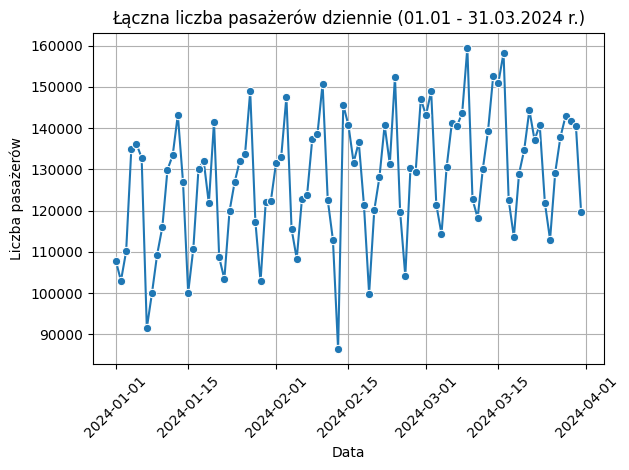

In [39]:
# Pogrupowanie danych o liczbie pasażerów według daty odbioru
daily_passengers = df_filtered.groupby('pickup_date')['passenger_count'].sum().reset_index()

# Wyświetlenie wykresu liniowego z dzienną liczbą pasażerów 
pu.lineplot(daily_passengers, x='pickup_date', y='passenger_count', xlabel='Data', ylabel='Liczba pasażerów', title='Łączna liczba pasażerów dziennie (01.01 - 31.03.2024 r.)')

**Komentarz:** Liczba przewiezionych pasażerów cechuje się wyraźnym trendem, a także wahaniami sezonowymi, które są zaburzane w okresie między 1 a 14 lutego (stąd też trudno oszacować typ wahań sezonowych). Największą liczbę pasażerów odnotowano między 1 a 15 marca (wynosiła ona **160000** pasażerów dziennie), zaś największy spadek został zaobserwowany między 1 a 14 lutego (poniżej **90000** pasażerów dziennie).

##### **Rozkład liczby pasażerów**

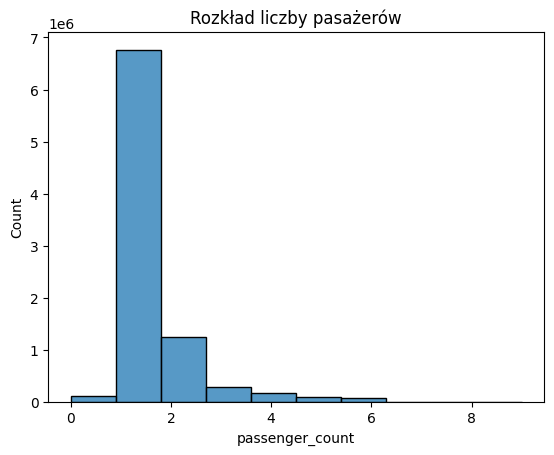

In [40]:
# Wyświetlenie rozkładu liczby pasażerów w formie histogramu
pu.histogram(df=df, col='passenger_count', title='Rozkład liczby pasażerów', bins=10, log_scale=False)

**Komentarz:** Rozkład liczby pasażerów jest jednomodalny (dominanta w tym przypadku wynosi **1**), zatem najczęściej z przejazdów taksówką korzystają pojedynczy pasażerowie. Widoczna jest również asymetria prawostronna rozkładu liczby pasażerów, zatem większa część kursów odbywa się z mniejszą liczbą pasażerów niż średnia (**1,33** osoby, czyli zwykle jest to jeden pasażer).

##### **Wykresy ramka-wąsy dla kosztu przejazdu względem dostawcy systemu (z pominięciem dodatkowych opłat)**

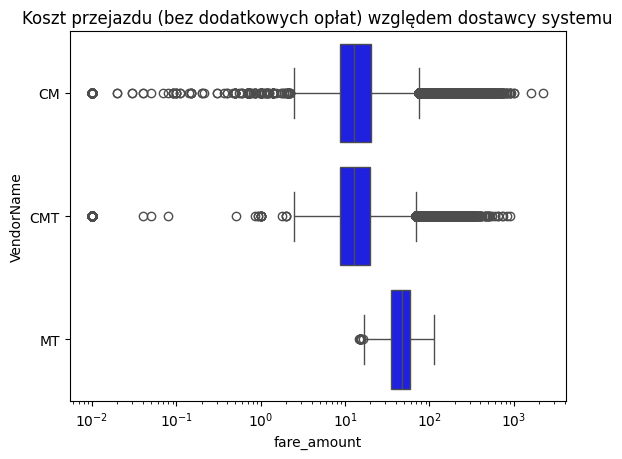

In [41]:
# Wyświetlenie rozkładu kosztu przejazdu względem dostawców systemu TPEP
pu.boxplot(df, x='fare_amount', y='VendorName', title='Koszt przejazdu (bez dodatkowych opłat) względem dostawcy systemu', log_scale=True)

In [42]:
# Wyświetlenie danych zgrupowanych w celu precyzyjnego opisania wyników na wykresie
df.groupby('VendorName')['fare_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
VendorName,,,,,,,,
CM,6622283.0,18.952958,17.978791,0.0,8.60,12.80,20.50,2221.3
CMT,2105409.0,17.846202,15.693210,0.0,8.60,12.80,19.80,900.0
MT,585.0,48.712171,18.445476,14.8,35.35,46.79,59.43,113.9


**Komentarz:** Porównując wykresy dla trzech dostawców systemu TPEP, można zauważyć, iż dane dotyczące kosztu przejazdu dla firm CMT (*Creative Mobile Technologies, LLC*) oraz CM (*Curb Mobility, LLC*) cechują się podobnym rozproszeniem, a także taką samą wartością mediany (**\\$12.80**). Oba rozkłady były również w przybliżeniu symetryczne (dolny kwartyl - **\\$8.60**, górny kwartyl - **\\$19.80** dla CMT i **\\$20.50** dla CM), o czym też świadczy umiejscowienie median oraz długość "wąsów", lecz cechowały się również licznymi wartościami odstającymi (**outlierami**), co świadczy zarówno o występowaniu bardzo niskich kosztów przejazdów (poniżej **\\$1**) szczególnie w przypadku firmy CM), a także bardzo wysokich (większych lub równych **\\$900**). 
W przeciwieństwie do pozostałych firm, firma MT (*Myle Technologies Inc*) cechowała się znacznie mniej rozproszonymi danymi na temat kosztu przejazdu taksówką, lecz również nie posiadała wielu wartości odstających, co też wynika z małej liczby danych związanych z tym dostawcą systemu. Mediana kosztów przejazdu była wyższa niż w przypadku pozostałych dwóch firm (**\\$46.79**), tak jak minimalny koszt przejazdu (**\\$14.80**), lecz maksymalna kwota była istotnie niższa (**\\$113.90**).
Podsumowując, połowa pasażerów taksówek korzystających z systemów CM i CMT płaci prawie **\\$34** mniej za swoje przejazdy niż pasażerowie jadący taksówką z systemem firmy MT.

##### **Wykresy ramka-wąsy dla pokonanej odległości względem dostawcy systemu**

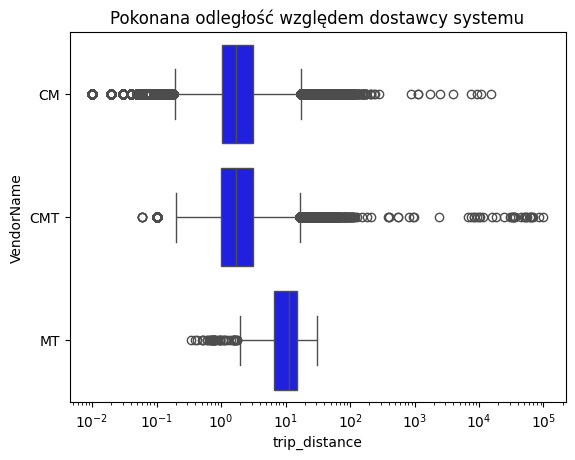

In [43]:
# Wyświetlenie rozkładu pokonanej odległości w trakcie przejazdu względem dostawców systemu TPEP
pu.boxplot(df, x='trip_distance', y='VendorName', title='Pokonana odległość względem dostawcy systemu', log_scale=True)

In [44]:
# Wyświetlenie danych zgrupowanych w celu precyzyjnego opisania wyników na wykresie
df.groupby('VendorName')['trip_distance'].describe()

,count,mean,std,min,25%,50%,75%,max
VendorName,,,,,,,,
CM,6622283.0,3.349384,9.993830,0.01,1.03,1.71,3.18,15400.32
CMT,2105409.0,3.720616,169.085125,0.06,1.00,1.70,3.10,98229.40
MT,585.0,11.208684,6.059324,0.34,6.57,11.28,15.26,30.31


**Komentarz:** Dokonując porównania wykresów dla trzech dostawców systemu TPEP, można dostrzec, że dane dotyczące pokonanej odległości w trakcie przejazdu dla firm CMT (*Creative Mobile Technologies, LLC*) oraz CM (*Curb Mobility, LLC*) ponownie są podobnie rozproszone, o czym świadczy niemalże identyczna wartość mediany (ok. **1,70** mili). Analogicznie do kosztu przejazdu, oba rozkłady były raz jeszcze w przybliżeniu symetryczne (dolny kwartyl - ok. **1** mili, górny kwartyl - **3.1** mili dla CMT i **3.18** mili dla CM), o czym też świadczy umiejscowienie median oraz długość "wąsów". Ponownie zauważono liczne wartości odstające, świadczące zarówno o występowaniu bardzo krótkich przejazdów (postoje), a także bardzo długich (większych lub równych **15400** mil), szczególnie w przypadku firmy CMT, gdzie kurs o najdłuższej trasie wynosił ok. **98229** mil (warto zwrócić uwagę na bardzo wysokie odchylenie standardowe równe ok. **169** mil). 
W przeciwieństwie do pozostałych firm, firma MT (*Myle Technologies Inc*) cechowała się znacznie mniej rozproszonymi danymi na temat kosztu przejazdu taksówką. Mediana pokonanej odległości była ponownie wyższa niż w przypadku pozostałych dwóch firm (**11.28** mili), tak jak minimalna trasa (**0.34** mili), lecz maksymalny kurs zajął zaledwie **30.31** mili.
Podsumowując, połowa pasażerów taksówek korzystających z systemów CM i CMT pokonuje zazwyczaj krótsze trasy w trakcie przejazdów niż pasażerowie jadący taksówką z systemem firmy MT. Wśród pasażerów jeżdżących taksówkami z systemem CMT występują znacznie częściej osoby, które podróżują na istotnie dłuższe dystanse.

##### **Łączna liczba pasażerów według dostawcy systemu**

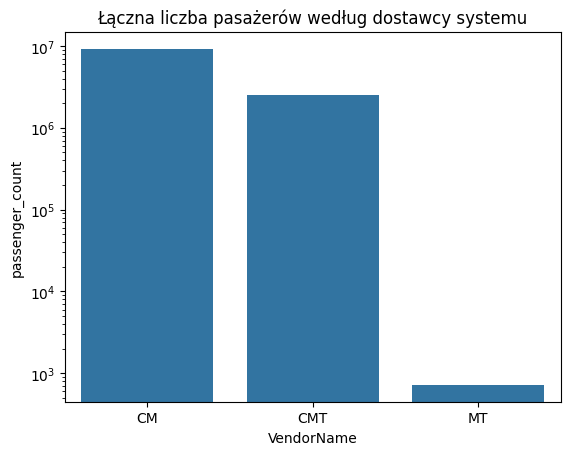

In [45]:
# Wyświetlenie sumarycznej liczby pasażerów według dostawców systemu TPEP
pu.barplot(passenger_sum, x='VendorName', y='passenger_count', title='Łączna liczba pasażerów według dostawcy systemu', log_y=True)

In [46]:
# Wyświetlenie danych zgrupowanych w celu precyzyjnego opisania wyników na wykresie
df.groupby('VendorName')['passenger_count'].count()

VendorName
CM     6622283
CMT    2105409
MT         585
Name: passenger_count, dtype: int64

**Komentarz:** Najczęściej pasażerowie poruszają się taksówkami obsługiwanymi przez dostawcę systemu TPEP, jakim jest CM (ponad **6 mln** pasażerów). Drugim dostawcą jest CMT (ponad **2 mln** pasażerów), a trzecim MT (**585** pasażerów), co też wynika z faktu, iż w pierwotnym zbiorze danych nie było podanej liczby pasażerów w trakcie kursu (została ona uzupełniona w oparciu o pozostałe dane), a sam dostawca występował rzadko w zbiorze danych.

##### **Korelacja między kolumnami numerycznymi**

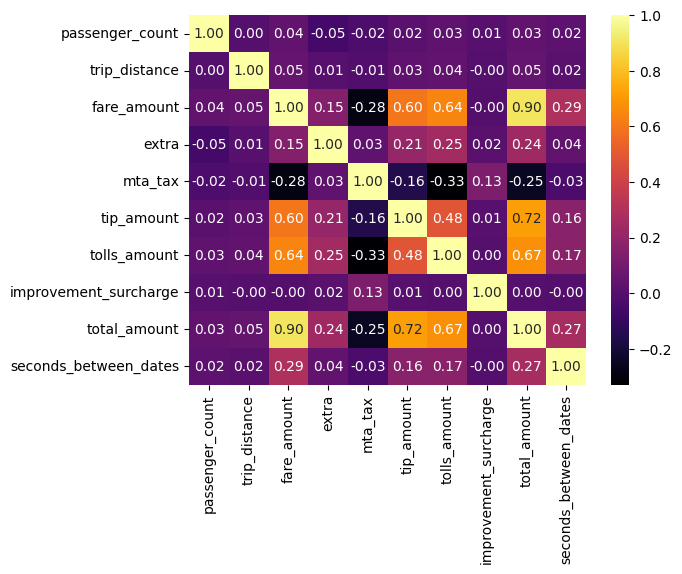

In [47]:
# Wyznaczenie listy kolumn do uwzględnienia w macierzy korelacji
excluded_keywords = ['pickup', 'dropoff', 'ID', 'payment']
corr_col_list = [col for col in df.columns
                 if not any(keyword.lower() in col.lower() for keyword in excluded_keywords)]

# Obliczenie macierzy korelacji na podstawie ramki danych
corr_matrix = df[corr_col_list].corr(numeric_only=True)

# Wyświetlenie macierzy korelacji w formie heatmapy
pu.corr_heatmap(corr_matrix)

**Komentarz:** Wśród analizowanych kolumn w ramce danych, najwyższą współczynnikiem korelacji liniowej cechowały się kolumny *fare_amount* i *total_amount*, co jest oczywiste, gdyż druga kolumna zbudowana jest w oparciu o pierwszą. Liczba pasażerów (*passenger_count*) cechowała się bardzo niską korelacją względem pozostałych kolumn, a zatem można twierdzić, iż związek liczby pasażerów z pozostałymi kolumnami jest niemalże znikomy. Na podstawie powyższej macierzy korelacji można również wyróżnić kilka kolumn stanowiących kandydatów na zmienne niezależne w modelu predykcyjnym, w którym zmienną zależną będzie *fare_amount* - koszt przejazdu wyliczony przez taksometr.

### Utworzenie modelu predykcyjnego

#### Import bibliotek wymaganych do oszacowania modeli predykcyjnych oraz pomiaru metryk ocen ich jakości

In [49]:
import time
import joblib
from scipy.stats import shapiro, probplot
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, PredictionErrorDisplay
from sklearn.preprocessing import StandardScaler

In [50]:
# Lista zmiennych ciągłych do testowania normalności ich rozkładów
columns_to_test = ['trip_distance', 'fare_amount', 'tip_amount', 'extra']

# Testowanie normalności rozkładów wybranych zmiennych ciągłych
for col in columns_to_test:
    stat, p = shapiro(df[col])
    if p < 0.05:
        print(f"Rozkład zmiennej {col} nie jest zgodny z rozkładem normalnym (p < 0.05).")
    else:
        print(f"Rozkład zmiennej {col} jest zgodny z rozkładem normalnym (p >= 0.05).")

C:\Users\ratch\Desktop\ds360-task-pmk\ds360-task-pmk\venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8728277.
  res = hypotest_fun_out(*samples, **kwds)


Rozkład zmiennej trip_distance nie jest zgodny z rozkładem normalnym (p < 0.05).
Rozkład zmiennej fare_amount nie jest zgodny z rozkładem normalnym (p < 0.05).
Rozkład zmiennej tip_amount nie jest zgodny z rozkładem normalnym (p < 0.05).
Rozkład zmiennej extra nie jest zgodny z rozkładem normalnym (p < 0.05).


In [51]:
# Wybór zmiennych wejściowych i wyjściowych
features = ['passenger_count', 'trip_distance', 'mta_tax', 'tip_amount', 'extra']
target = 'fare_amount'

In [52]:
# Utworzenie zbiorów danych wejściowych i wyjściowych
X = df[features]
y = df[target]

# Podział danych wejściowych i wyjściowych na zbiory treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
# Skalowanie danych w celu użycia ich z częścią modeli predykcyjnych
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [54]:
# Utworzenie listy modeli predykcyjnych do uczenia
model_list = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(max_depth=2, random_state=42),
    "KNN Regressor": KNeighborsRegressor(n_neighbors=5),
    "MLP Regressor": MLPRegressor(tol=0.1, max_iter=2000, random_state=42)
}

In [55]:
# Utworzenie pustych list przeznaczonych do przechowywania nauczonych modeli, wyników predykcji oraz metryk oceny jakości modeli
trained_models = []
results = []
y_pred_list = []

In [56]:
# Uczenie modeli na podstawie ustalonych danych treningowych i testowych
for name, model in model_list.items():
    # Dostosowanie danych wejściowych
    if name in ['MLP Regressor', 'KNN Regressor', 'Linear Regression']:
        X_train_input = X_train_scaled 
        X_test_input = X_test_scaled
    else:
        X_train_input = X_train
        X_test_input = X_test

    # Trening modelu i mierzenie czasu uczenia modelu
    start_time = time.time()
    model.fit(X_train_input, y_train)
    end_time = time.time()
    train_time = end_time - start_time
    
    # Predykcja na podstawie nauczonego modelu
    y_pred = model.predict(X_test_input)

    # Zapisywanie wyników
    trained_models.append(model)
    y_pred_list.append(y_pred) 

    # Obliczenie metryk
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Przypisanie metryk oceny jakości modelu i czasu jego uczenia do słownika
    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'Czas uczenia': round(train_time, 3)
    })

In [57]:
# Wyświetlenie wyników przeprowadzonego uczenia modeli predykcyjnych
results_df = pd.DataFrame(results)
results_df

,Model,MAE,RMSE,R2,Czas uczenia
0,Linear Regression,8.054993,13.871387,0.375951,0.667
1,Ridge Regression,8.054991,13.871359,0.375954,0.364
2,Random Forest,4.197865,8.135307,0.785352,194.235
3,KNN Regressor,1.431654,4.914728,0.921661,24.082
4,MLP Regressor,2.231796,5.530527,0.900800,187.663


**Komentarz:** Spośród pięciu wybranych modeli predykcyjnych, najlepsze wyniki otrzymano dla modelu *KNN Regressor*, dla którego wartości błędów MAE i RMSE były najniższe (odpowiednio, **1,432** oraz **4,915**), zaś współczynnik determinacji R^2 - najwyższy (**0,922**) i czas uczenia wyniósł ok. 24 sekund. Warto jednak zauważyć, że czas poświęcony na predykcję w oparciu o dane testowe był znacznie dłuższy niż w przypadku modelu *MLP Regressor*, który zwrócił nieznacznie słabsze wyniki (R^2 = **0,900** vs 0,922), jednocześnie potrzebując znacznie mniej czasu na predykcję. Wynika to z faktu, iż jest to model parametryczny, który nie wymaga rozpatrywania wszystkich wariantów na nowo, tak jak to ma miejsce w przypadku modelu *KNN Regressor*. Stąd też podjęto decyzję, aby w kolejnej części analizy modelu predykcyjnego pozostać przy modelu perceptronowym wielowarstwowym.

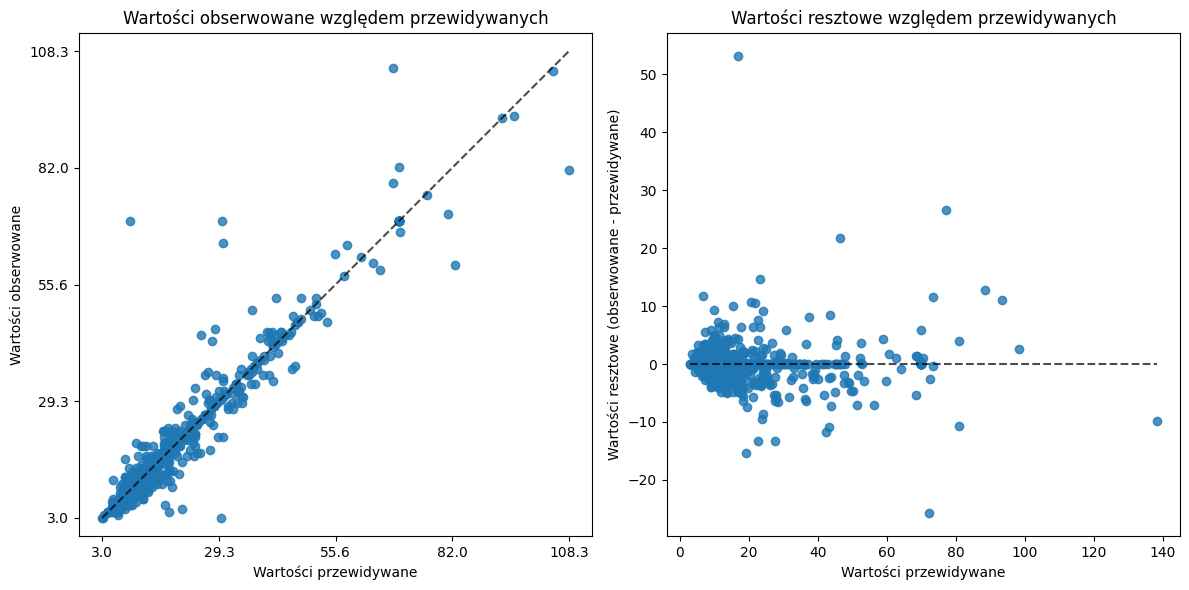

In [73]:
# Wyświetlenie wykresów dla modelu KNN Regressor
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
PredictionErrorDisplay.from_predictions(y_true=y_test, y_pred=y_pred_list[-2], kind='actual_vs_predicted', ax=axes[0])
axes[0].set_title("Wartości obserwowane względem przewidywanych")
axes[0].set_xlabel("Wartości przewidywane")
axes[0].set_ylabel("Wartości obserwowane")
PredictionErrorDisplay.from_predictions(y_true=y_test, y_pred=y_pred_list[-2], ax=axes[1])
axes[1].set_title("Wartości resztowe względem przewidywanych")
axes[1].set_xlabel("Wartości przewidywane")
axes[1].set_ylabel("Wartości resztowe (obserwowane - przewidywane)")
plt.tight_layout()
plt.show()

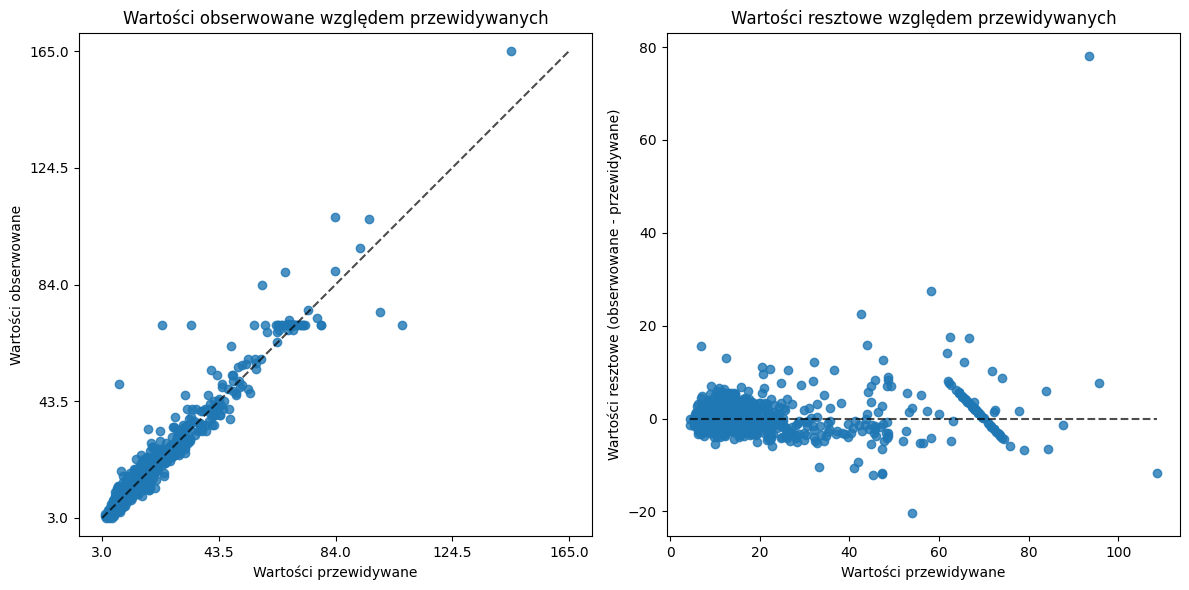

In [59]:
# Wyświetlenie wykresów dla modelu MLP Regressor
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
PredictionErrorDisplay.from_predictions(y_true=y_test, y_pred=y_pred_list[-1], kind='actual_vs_predicted', ax=axes[0])
axes[0].set_title("Wartości obserwowane względem przewidywanych")
axes[0].set_xlabel("Wartości przewidywane")
axes[0].set_ylabel("Wartości obserwowane")
PredictionErrorDisplay.from_predictions(y_true=y_test, y_pred=y_pred_list[-1], ax=axes[1])
axes[1].set_title("Wartości resztowe względem przewidywanych")
axes[1].set_xlabel("Wartości przewidywane")
axes[1].set_ylabel("Wartości resztowe (obserwowane - przewidywane)")
plt.tight_layout()
plt.show()

In [60]:
# Rozszerzenie zbioru danych o zmienne typu one-hot (zmienne sztuczne)
df_encoded = pd.get_dummies(df, columns=['VendorName'], drop_first=True)
ext_features = features + ['seconds_between_dates', 'VendorName_CMT', 'VendorName_MT']

In [61]:
# Ponowny podział danych na zbiory treningowy i testowy
ext_X = df_encoded[ext_features]
ext_y = df_encoded[target]
ext_X_train, ext_X_test, ext_y_train, ext_y_test = train_test_split(ext_X, ext_y, test_size=0.2, random_state=42)

In [62]:
# Przeskalowanie danych w obu zbiorach
ext_X_train_scaled = scaler.fit_transform(ext_X_train)
ext_X_test_scaled = scaler.transform(ext_X_test)

In [63]:
# Uczenie rozszerzonego modelu predykcyjnego w oparciu o dane treningowe
ext_mlp_model = MLPRegressor(tol=0.1, max_iter=2000, random_state=42)
ext_mlp_model.fit(ext_X_train_scaled, ext_y_train)

MLPRegressor(max_iter=2000, random_state=42, tol=0.1)

In [64]:
# Dokonanie predykcji w oparciu o dane testowe
ext_mlp_y_pred = ext_mlp_model.predict(ext_X_test_scaled)

# Wyznaczenie wartości metryk oceny jakości modelu
ext_mlp_mae = mean_absolute_error(ext_y_test, ext_mlp_y_pred)
ext_mlp_rmse = np.sqrt(mean_squared_error(ext_y_test, ext_mlp_y_pred))
ext_mlp_r2 = r2_score(ext_y_test, ext_mlp_y_pred)

# Wyświetlenie wartości metryk oceny jakości modelu
print(f"MAE: {ext_mlp_mae:.3f}")
print(f"RMSE: {ext_mlp_rmse:.3f}")
print(f"R^2: {ext_mlp_r2:.3f}")

MAE: 1.048
RMSE: 4.464
R^2: 0.935


In [65]:
# Zapis nauczonego modelu predykcyjnego opartego o wielowarstwowy perceptron
joblib.dump(ext_mlp_model, 'ext_mlp_model.pkl')

['ext_mlp_model.pkl']

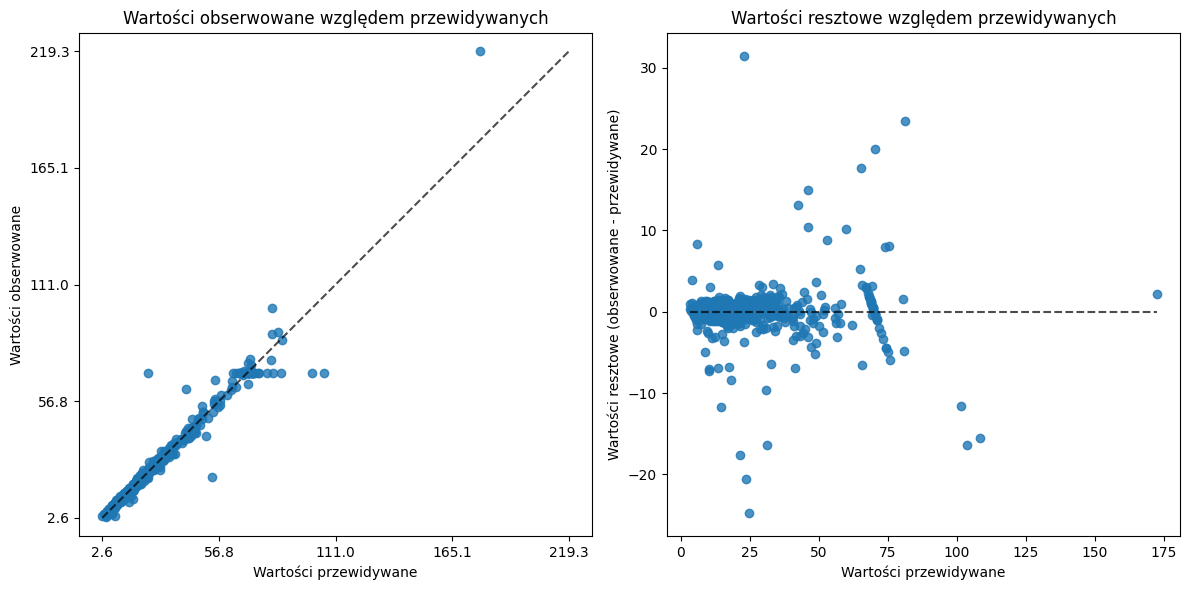

In [66]:
# Wyświetlenie wykresów dla rozszerzonego modelu MLP Regressor
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
PredictionErrorDisplay.from_predictions(y_true=ext_y_test, y_pred=ext_mlp_y_pred, kind='actual_vs_predicted', ax=axes[0])
axes[0].set_title("Wartości obserwowane względem przewidywanych")
axes[0].set_xlabel("Wartości przewidywane")
axes[0].set_ylabel("Wartości obserwowane")
PredictionErrorDisplay.from_predictions(y_true=ext_y_test, y_pred=ext_mlp_y_pred, ax=axes[1])
axes[1].set_title("Wartości resztowe względem przewidywanych")
axes[1].set_xlabel("Wartości przewidywane")
axes[1].set_ylabel("Wartości resztowe (obserwowane - przewidywane)")
plt.tight_layout()
plt.show()

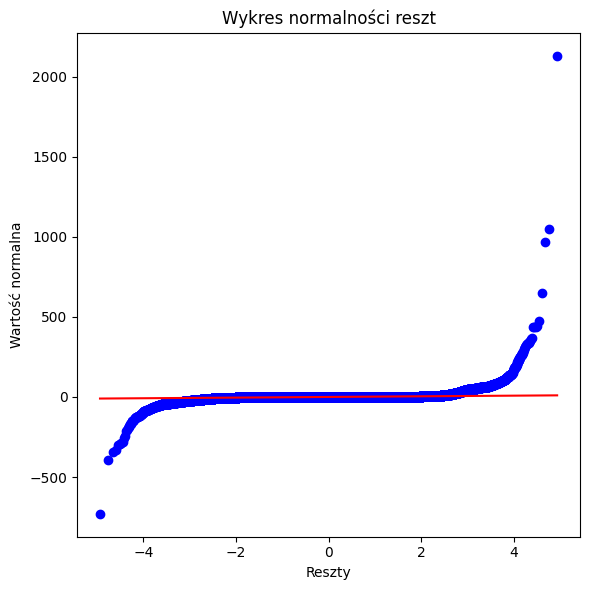

In [67]:
# Obliczenie reszt rozszerzonego modelu
residuals = ext_y_test - ext_mlp_y_pred

# Narysowanie wykresu normalności reszt dla tego modelu
plt.figure(figsize=(6, 6))
probplot(residuals, dist="norm", plot=plt)
plt.title("Wykres normalności reszt")
plt.xlabel("Reszty")
plt.ylabel("Wartość normalna")
plt.tight_layout()
plt.show()

In [68]:
# Inicjalizacja i uczenie rozszerzonego modelu MLP Regressor ze zmienionymi parametrami
next_mlp_model = MLPRegressor(
    hidden_layer_sizes=(128, 64),
    alpha=0.001,
    tol=0.001,
    learning_rate_init=0.01,
    max_iter=2000,
    early_stopping=True,
    random_state=42
)
next_mlp_model.fit(ext_X_train_scaled, ext_y_train)

MLPRegressor(alpha=0.001, early_stopping=True, hidden_layer_sizes=(128, 64),
             learning_rate_init=0.01, max_iter=2000, random_state=42,
             tol=0.001)

In [71]:
# Dokonanie predykcji w oparciu o dane testowe
next_mlp_y_pred = next_mlp_model.predict(ext_X_test_scaled)

# Wyznaczenie wartości metryk oceny jakości modelu
next_mlp_mae = mean_absolute_error(ext_y_test, next_mlp_y_pred)
next_mlp_rmse = np.sqrt(mean_squared_error(ext_y_test, next_mlp_y_pred))
next_mlp_r2 = r2_score(ext_y_test, next_mlp_y_pred)

# Wyświetlenie wartości metryk oceny jakości modelu
print(f"MAE: {next_mlp_mae:.2f}")
print(f"RMSE: {next_mlp_rmse:.3f}")
print(f"R^2: {next_mlp_r2:.2f}")

MAE: 1.03
RMSE: 4.226
R^2: 0.94


In [75]:
# Zapis nauczonego rozszerzonego modelu predykcyjnego opartego o wielowarstwowy perceptron
joblib.dump(next_mlp_model, 'next_mlp_model.pkl')

['next_mlp_model.pkl']